In [1]:
# TODO: Eventually, I need to include comparisons with the scipy conjguate gradient method

In [1]:
import numpy as np
import tensorflow as tf
from sopt.optimizers.tensorflow2.utils import BackTrackingLineSearch, AdaptiveLineSearch
import matplotlib.pyplot as plt
from sopt.optimizers.tensorflow2 import NonLinearConjugateGradient


gpu = tf.config.experimental.list_physical_devices('GPU')[0]
tf.config.experimental.set_memory_growth(gpu, True)

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
x_guess = np.random.randn(100).astype('float32') * 20

# Conjugate gradient method 

In [5]:

objective_fn = lambda x: 0.5 * tf.reduce_sum((x - 2)**2) 
mean_fn = lambda x: tf.reduce_mean(x).numpy()

def obj_and_upd_fn(x, y): 
    fnval = objective_fn(x + y)
    return fnval, x + y

v1 = tf.Variable(x_guess)
v2 = tf.Variable(x_guess)

opt1 = NonLinearConjugateGradient(input_var=v1, objective_fn=objective_fn, name='cg1',
                                 linesearch_type='backtracking')
opt2 = NonLinearConjugateGradient(input_var=v2, 
                                 objective_fn=objective_fn,
                                 name='cg2',
                                 linesearch_type='adaptive')

In [6]:
cg_losses_bls = []
cg_means_bls = []
cg_losses_als = []
cg_means_als = []

In [7]:
%%time
for i in range(20):
    cg_losses_bls.append(opt1.minimize().numpy())
    cg_losses_als.append(opt2.minimize().numpy())
    cg_means_bls.append(mean_fn(v1))
    cg_means_als.append(mean_fn(v2))

CPU times: user 2.76 s, sys: 51.4 ms, total: 2.81 s
Wall time: 2.71 s


# Comparison to backtracking and adaptive gradient descent

In [8]:
v1 = tf.Variable(x_guess)
v2 = tf.Variable(x_guess)
bls_steps = tf.Variable(0, dtype='int32')
als_steps = tf.Variable(0, dtype='int32')


def loss_grad_fn(x):
    with tf.GradientTape() as gt:
        loss = objective_fn(x)
    return loss, gt.gradient(loss, x)

def linesearch_update(ls, v):
    loss, grad = loss_grad_fn(v)
    ls_out = ls.search(obj_and_upd_fn, v, -grad, grad, loss)
    v.assign(ls_out.newx)
    return ls_out.newf, mean_fn(v)


bls = BackTrackingLineSearch(initial_stepsize=1.0, optimism=3.0)
als = AdaptiveLineSearch(initial_stepsize=1.0)

In [9]:
bls_losses = []
bls_means = []
als_losses = []
als_means = []

In [10]:
%%time
for i in range(20):
    loss1, mean1 = linesearch_update(bls, v1)
    bls_losses.append(loss1.numpy())
    bls_means.append(mean1)
    
    loss2, mean2 = linesearch_update(als, v2)
    als_losses.append(loss2.numpy())
    als_means.append(mean2)

CPU times: user 693 ms, sys: 23.1 ms, total: 716 ms
Wall time: 624 ms


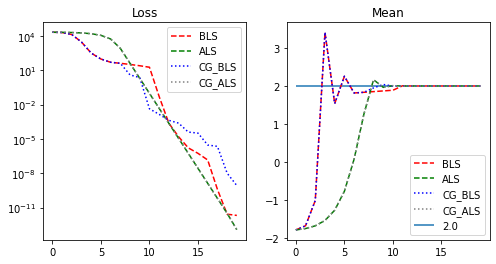

In [11]:
# Final mean should be 2.0

plt.figure(figsize=[8,4])
plt.subplot(1, 2, 1)
plt.plot(bls_losses, color='red', ls='--', label='BLS')
plt.plot(als_losses, color='green', ls='--', label='ALS')
plt.plot(cg_losses_bls, color='blue', ls=':', label='CG_BLS')
plt.plot(cg_losses_als, color='grey', ls=':', label='CG_ALS')
plt.yscale('log')
plt.title('Loss')
plt.legend(loc='best')
plt.subplot(1,2,2)
plt.plot(bls_means, color='red', ls='--', label='BLS')
plt.plot(als_means, color='green', ls='--', label='ALS')
plt.plot(cg_means_bls, color='blue', ls=':', label='CG_BLS')
plt.plot(cg_means_als, color='grey', ls=':', label='CG_ALS')
plt.hlines(2.0, xmin=0, xmax=10, label='2.0')
#plt.yscale('log')
plt.title('Mean')
plt.legend(loc='best')
plt.show()

In [12]:
als_means, cg_means_als

([-1.7858521,
  -1.7497424,
  -1.6782116,
  -1.5378792,
  -1.2679225,
  -0.76920724,
  0.07600628,
  1.2504838,
  2.1655488,
  1.9634347,
  2.0080764,
  1.9982162,
  2.0003939,
  1.9999129,
  2.0000193,
  1.9999957,
  2.000001,
  1.9999996,
  2.0,
  2.0],
 [-1.7858521,
  -1.7497424,
  -1.6782113,
  -1.5378792,
  -1.2679225,
  -0.76920724,
  0.076006316,
  1.2504838,
  2.165549,
  1.9634345,
  2.0080764,
  1.9982162,
  2.0003939,
  1.9999129,
  2.0000193,
  1.9999957,
  2.000001,
  1.9999996,
  2.0,
  2.0])